In [1]:
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
import pandas as pd
import datetime
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

C:\Users\Vance He\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def xgb_feature(X_train, y_train, X_test, y_test=None):
    # model parameters
    params = {'booster': 'gbtree',
              'objective': 'rank:pairwise',
              'eval_metrix': 'auc',
              'eta': 0.02,
              'max_depth': 5, #4,3
              'colsample_bytree': 0.7, #0.8
              'subsample': 0.7,
              'min_child_weight': 1, #2,3
              'seed': 1111,
              'silent': 1
             }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=800)
    predict = model.predict(dvali)
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x - min_pred)/(max_pred - min_pred))
    return vfunc(predict)

def xgb_feature2(X_train, y_train, X_test, y_test=None):
    # model parameters
    params = {'booster': 'gbtree',
              'objective': 'rank:pairwise',
              'eval_metrix': 'auc',
              'eta': 0.015,
              'max_depth': 5, #4,3
              'colsample_bytree': 0.7, #0.8
              'subsample': 0.7,
              'min_child_weight': 1, #2,3
              'seed': 11,
              'silent': 1
             }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=1200)
    predict = model.predict(dvali)
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x - min_pred)/(max_pred - min_pred))
    return vfunc(predict)

def xgb_feature3(X_train, y_train, X_test, y_test=None):
    # model parameters
    params = {'booster': 'gbtree',
              'objective': 'rank:pairwise',
              'eval_metrix': 'auc',
              'eta': 0.01,
              'max_depth': 5, #4,3
              'colsample_bytree': 0.7, #0.8
              'subsample': 0.7,
              'min_child_weight': 1, #2,3
              'seed': 1,
              'silent': 1
             }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvali = xgb.DMatrix(X_test)
    model = xgb.train(params, dtrain, num_boost_round=2000)
    predict = model.predict(dvali)
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x - min_pred)/(max_pred - min_pred))
    return vfunc(predict)

def et_model(X_train, y_train, X_test, y_test=None):
    model = ExtraTreesClassifier(max_features='log2', n_estimators=1000, n_jobs=-1).fit(X_train, y_train)
    return model.predict_proba(x_test)[:, 1]

def gbdt_model(X_train, y_train, X_test, y_test=None):
    model = GradientBoostingClassifier(learning_rate=0.02, max_features=0.7, n_estimators=700, max_depth=5).fit(X_train,y_train)
    predict = model.predict_proba(X_test)[:, 1]
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x - min_pred)/(max_pred - min_pred))
    return vfunc(predict)

def logistic_model(x_train, y_train, x_test, y_test=None):
    model = LogisticRegression(penalty='l2').fit(x_train, y_train)
    return model.predict_proba(x_test)[:, 1]

def lgb_feature(X_train, y_train, X_test, y_test=None):
    lgb_train = lgb.Dataset(X_train, y_train, 
                            categorical_feature ={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
    lgb_test = lgb.Dataset(X_test, categorical_feature={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metrix': 'auc',
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_data_in_leaf': 5,
        'max_bin': 200,
        'verbose': 0,
    }
    gbm = lgb.train(params, lgb_train, num_boost_round=2000)
    predict = gbm.predict(X_test)
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))
    return vfunc(predict)

### apply models

In [78]:
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/train_data_one_hot.csv",
                        parse_dates=['appl_sbm_tm'])

In [79]:
# split the training set and the testing set
train_set = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_set = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

In [11]:
test_set.shape

(33755, 91)

In [12]:
train_set.shape

(87174, 91)

In [13]:
sum(test_set['target'][test_set['target']==1])

975

In [14]:
sum(train_set['target'][train_set['target']==1])

2413

In [15]:
max(train_set.appl_sbm_tm)

Timestamp('2017-03-29 23:59:30')

In [16]:
min(train_set.appl_sbm_tm)

Timestamp('2016-03-28 09:23:58')

In [18]:
# drop response column
train_set = train_set.drop(['target'], axis=1)

In [80]:
# training data_set
train_data_set = train_set[(train_set.year <= 2017) & (train_set.month <= 5)]
valid_data_set = train_set[(train_set.year >= 2016) & (train_set.month > 5)]

In [81]:
train_data_set.shape

(63324, 119)

In [82]:
valid_data_set.shape

(23850, 119)

In [59]:
sum(train_data_set['target'][train_data_set['target']==1])

1536

In [60]:
sum(valid_data_set['target'][valid_data_set['target']==1])

877

In [85]:
for col in train_data_x.columns:
    print("{} {}".format(train_data_x[col].dtypes, col))

datetime64[ns] appl_sbm_tm
object id
object id_card_x
object auth_time
object phone
int64 spt_id_card_x
int64 phone_exist_x
int64 auth_time_year
int64 auth_time_month
int64 auth_time_day
object birthday
object id_card_y
float64 credit_score
float64 overdraft
float64 quota
float64 remaining
float64 using_rate
float64 inverse_credit_score
int64 hour
int64 month
int64 year
int64 nan_num
float64 diff_day
float64 how_old
int64 the_same_id
int64 exist_phone
int64 bank_name_len
int64 tail_num_len
int64 Online Pay
int64 Cash on Delivery
int64 is_double
int64 is_0_0_0
int64 is_0000_00_00
int64 is_0001_1_1
int64 AH
int64 BJ
int64 CQ
int64 FJ
int64 GD
int64 GS
int64 GX
int64 GZ
int64 HA
int64 HB
int64 HE
int64 HI
int64 HK
int64 HL
int64 HN
int64 JL
int64 JS
int64 JX
int64 LN
int64 NM
int64 NX
int64 QH
int64 SC
int64 SD
int64 SH
int64 SN
int64 SX
int64 TJ
int64 TW
int64 XJ
int64 XZ
int64 YN
int64 ZJ
int64 unknown
int64 receive_phone_count
int64 unique_fix_phone
int64 bank_phone_num
int64 is_hobby


In [73]:
train_data_x['unknown'].unique()

array([0, 1, 7, 4], dtype=int64)

In [ ]:
train_data_x = train_data_set.drop(['unknown'], axis=1)
valid_data_x = valid_data_set.drop(['unknown'], axis=1)

In [84]:
#train_data = pd.read_csv()
#train_data = train_data.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'hobby', 'id_card_y'], axis=1)
train_data_x = train_data_set.drop(['target'], axis=1)
valid_data_x = valid_data_set.drop(['target'], axis=1)

In [87]:
train_data_x = train_data_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
valid_data_x = valid_data_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)

In [88]:
train_data_x = train_data_x.fillna(0)
valid_data_x = valid_data_x.fillna(0)

In [89]:
# Logistic Model
redict_result = logistic_model(train_data_x, train_data_set['target'].values, valid_data_x, None)
print('valid auc', roc_auc_score(valid_data_set['target'].values, redict_result))

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


valid auc 0.5662629041349965


D:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [94]:
model = LogisticRegression(penalty='l2').fit(train_data_x, train_data_set['target'].values)

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [95]:
lr_result = model.predict(valid_data_x) 

In [100]:
print('MCC: {}'.format(matthews_corrcoef(valid_data_set['target'].values, lr_result)))

MCC: 0.0


### stacking & lgb

In [118]:
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/train_data.csv",
                        parse_dates=['appl_sbm_tm'])
#data = data.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)

In [119]:
# split training and test set
train_data = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_data = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

In [120]:
# label encoding & light gbm dataset
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound', 'account_grade']
for _fea in dummy_fea:
    print(_fea)
    le = LabelEncoder()
    le.fit(train_data[_fea].tolist() + test_data[_fea].tolist())
    tmp =le.transform(train_data[_fea].tolist() + test_data[_fea].tolist())
    train_data[_fea] = tmp[:train_data.shape[0]]
    test_data[_fea] = tmp[train_data.shape[0]:]
train_x = train_data.drop(['target'] ,axis=1)
test_x = test_data.drop(['target'], axis=1)
train_x = train_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
test_x = test_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
lgb_dataset = Dataset(train_x, train_data['target'], test_x, use_cache=False)

sex
merriage


D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


income
qq_bound
degree
wechat_bound
account_grade


In [121]:
# xgb dataset
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/train_data_one_hot.csv",
                        parse_dates=['appl_sbm_tm'])
#data = data.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'hobby', 'id_card_y'], axis=1)

In [122]:
# split training and test set
train_data = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_data = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

In [123]:
train_x = train_data.drop(['target'] ,axis=1)
test_x = test_data.drop(['target'], axis=1)
train_x = train_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
test_x = test_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
xgb_dataset = Dataset(X_train=train_x, y_train=train_data['target'], X_test=test_x, y_test=None, use_cache=False)

In [124]:
# heamy
model_xgb = Regressor(dataset=xgb_dataset, estimator=xgb_feature, name='xgb', use_cache=False)
model_xgb2 = Regressor(dataset=xgb_dataset, estimator=xgb_feature2, name='xgb', use_cache=False)
model_xgb3 = Regressor(dataset=xgb_dataset, estimator=xgb_feature3, name='xgb', use_cache=False)
model_lgb = Regressor(dataset=lgb_dataset, estimator=lgb_feature, name='lgb', use_cache=False)
model_gbdt = Regressor(dataset=xgb_dataset, estimator=gbdt_model, name='gbdt', use_cache=False)
pipeline = ModelsPipeline(model_xgb, model_xgb2, model_xgb3, model_lgb, model_gbdt)
stack_ds = pipeline.stack(k=5, seed=111, add_diff=False, full_test=True)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression, parameters={'fit_intercept':False})
predict_result = stacker.predict()

D:\anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [126]:
len(predict_result)

33755

In [127]:
test_set.shape

(33755, 91)

In [128]:
test_set['prob'] = predict_result

In [129]:
test_set.head()

,appl_sbm_tm,target,id,id_card_x,auth_time,phone,spt_id_card_x,phone_exist_x,auth_time_year,auth_time_month,...,day_order_max,day_order_min,order_time,order_mean,unit_price_mean,order_time_set,order_std,order_skew,order_sum,prob
0,2017-04-08 19:10:13,0,600689284231467016,4****************2,2017-03-05,China Mobile,1,1,2017,3,...,439.0,445.0,4.0,95.750000,NaN,3,70.196747,1.653270,383.00,0.025455
3,2017-03-30 08:45:55,0,593852820159991816,NaN,NaN,China Unicom,0,1,-1,-1,...,2.0,430.0,60.0,1125.125833,NaN,56,1855.334525,1.580385,67507.55,0.003818
6,2017-04-18 12:52:37,0,607748277420429320,NaN,NaN,China Mobile,0,1,-1,-1,...,91.0,235.0,4.0,83.225000,NaN,2,51.985278,0.165577,332.90,0.007364
14,2017-04-28 07:21:31,0,614829617332621576,4****************X,NaN,China Telecom,1,1,-1,-1,...,NaN,NaN,1.0,NaN,NaN,1,NaN,NaN,0.00,0.012071
16,2017-04-02 23:24:54,0,596469748414288136,3****************2,2016-12-15,China Mobile,1,1,2016,12,...,NaN,NaN,1.0,NaN,NaN,1,NaN,NaN,0.00,0.025796


In [130]:
test_set = test_set.drop(['appl_sbm_tm'], axis=1)

In [131]:
minmin, maxmax = min(test_set['prob']), max(test_set['prob'])
test_set['prob_normal'] = test_set['prob'].map(lambda x: (x-minmin)/(maxmax-minmin))
test_set['prob_normal'] = test_set['prob_normal'].map(lambda x: '%.4f' % x)

In [132]:
test_set['prob_normal'].head()

0     0.0545
3     0.0133
6     0.0200
14    0.0290
16    0.0551
Name: prob_normal, dtype: object

In [134]:
test_set.to_csv('C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/test_res_stacking.csv', index=False)

In [191]:
# 0.06
test_set['pred'] = test_set['prob_normal'].map(lambda x: (float(x) > 0.06)*1)

In [192]:
print('MCC: {}'.format(matthews_corrcoef(test_set['target'].values, test_set['pred'].values)))

MCC: 0.1749260634665707


In [193]:
print('valid auc', roc_auc_score(test_set['target'].values, test_set['pred'].values))

valid auc 0.7249582296897734


### lightgbm

In [75]:
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/train_data.csv",
                        parse_dates=['appl_sbm_tm'])

In [76]:
# label encoding & light gbm dataset
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound', 'account_grade']
for _fea in dummy_fea:
    print(_fea)
    le = LabelEncoder()
    le.fit(data[_fea].tolist())
    data[_fea] =le.transform(data[_fea].tolist())

sex
merriage
income
qq_bound
degree
wechat_bound
account_grade


In [34]:
data['degree'].unique()

array([8, 3, 2, 1, 7, 0, 4, 6, 5], dtype=int64)

In [77]:
# split training and test set
train_set = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_set = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

In [39]:
train_x = train_set.drop(['target'] ,axis=1)
test_x = test_data.drop(['target'], axis=1)
train_x = train_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
test_x = test_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)

In [18]:
train_x['degree'].unique()

array([8, 3, 2, 1, 0, 7, 4, 6, 5], dtype=int64)

In [40]:
lgb_train = lgb.Dataset(train_x, train_set['target'].values, 
                            categorical_feature ={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
#lgb_test = lgb.Dataset(valid_x, categorical_feature={'sex', 'merriage', 'income', 'qq_bound',
                                                  #'degree', 'wechat_bound', 'account_grade'})
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrix': 'auc',
    'num_leaves': 25,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'max_bin': 200,
    'verbose': 0,
}
gbm = lgb.train(params, lgb_train, num_boost_round=2000)
predict = gbm.predict(valid_x)
min_pred = min(predict)
max_pred = max(predict)
lgb_result = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))

In [45]:
result = lgb_result(predict)

In [67]:
predictions_lgb = np.where(result > 0.05, 1, 0)

In [50]:
predictions_lgb

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
print('valid auc:{}, MCC: {}'.format(roc_auc_score(valid_set['target'].values, predictions_lgb),
                                     matthews_corrcoef(valid_set['target'].values, predictions_lgb)))

valid auc:0.7054027679412067, MCC: 0.18300152867394265


In [69]:
predict = gbm.predict(test_x)
min_pred = min(predict)
max_pred = max(predict)
lgb_result = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))
result = lgb_result(predict)

In [74]:
predictions_lgb = np.where(result > 0.05, 1, 0)
print('valid auc:{}, MCC: {}'.format(roc_auc_score(test_data['target'].values, predictions_lgb),
                                     matthews_corrcoef(test_data['target'].values, predictions_lgb)))

valid auc:0.6741061622940818, MCC: 0.16715604630799008


### use train/test only

In [2]:
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/train_data.csv",
                        parse_dates=['appl_sbm_tm'])
# label encoding & light gbm dataset
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound', 'account_grade']
for _fea in dummy_fea:
    print(_fea)
    le = LabelEncoder()
    le.fit(data[_fea].tolist())
    data[_fea] =le.transform(data[_fea].tolist())

sex
merriage
income
qq_bound
degree
wechat_bound
account_grade


In [3]:
# split training and test set
train_data = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_data = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

In [4]:
train_x = train_data.drop(['target'] ,axis=1)
test_x = test_data.drop(['target'], axis=1)
train_x = train_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)
test_x = test_x.drop(['appl_sbm_tm', 'id', 'id_card_x', 'auth_time', 'phone', 'birthday', 'id_card_y'], axis=1)

In [7]:
lgb_result = lgb_feature(train_x, train_data['target'].values, test_x, None)

D:\anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [7]:
predictions_lgb = np.where(lgb_result > 0.05, 1, 0)

In [8]:
print('valid auc', roc_auc_score(test_data['target'].values, predictions_lgb))
#print('valid auc', roc_auc_score(test_data['target'].values, lgb_result))

valid auc 0.6907719685236463


In [9]:
print('MCC: {}'.format(matthews_corrcoef(test_data['target'].values, predictions_lgb)))

MCC: 0.1701219108648011


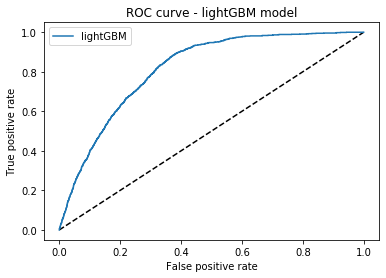

In [8]:
fpr_rf, tpr_rf, _ = roc_curve(test_data['target'].values, lgb_result)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='lightGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - lightGBM model')
plt.legend(loc='best')
plt.show()

In [9]:
print('valid auc', roc_auc_score(test_data['target'].values, lgb_result))

valid auc 0.8149153799220913


<Figure size 432x288 with 0 Axes>

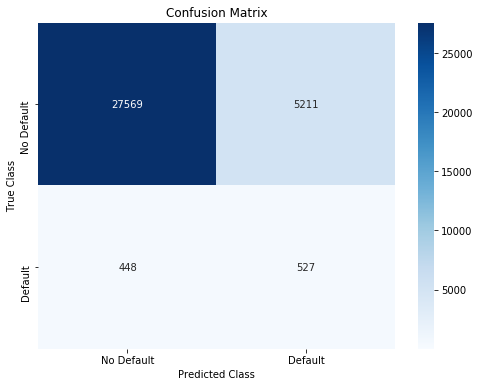

In [11]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_data['target'].values, predictions_lgb)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [95]:
#Print accuracy
acc_lgbm = accuracy_score(test_data['target'].values, predictions_lgb)
print('Overall accuracy of Light GBM model:', acc_lgbm)

Overall accuracy of Light GBM model: 0.8323507628499481


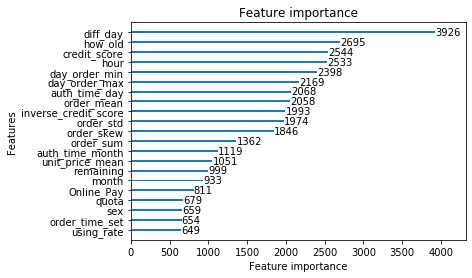

In [97]:
#Plot Variable Importances
lgb.plot_importance(gbm, max_num_features=21, importance_type='split', grid=False)

### Optimize Lightgbm model

In [2]:
# import data
data = pd.read_csv("C:/Users/Vance He/Desktop/UMich/2020_WN/STATS507/project/project/data/processed_data/data_truncated.csv",
                        parse_dates=['appl_sbm_tm'])

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)

In [4]:
# label encoding & light gbm dataset
dummy_fea = ['sex', 'merriage', 'income', 'qq_bound', 'degree', 'wechat_bound', 'account_grade', 'phone']
for _fea in dummy_fea:
    print(_fea)
    le = LabelEncoder()
    le.fit(data[_fea].tolist())
    data[_fea] =le.transform(data[_fea].tolist())

sex
merriage
income
qq_bound
degree
wechat_bound
account_grade
phone


In [5]:
# split the training set and the testing set
train_set = data[data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_set = data[data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

test_set = test_set.drop(['appl_sbm_tm'], axis=1)
train_set = train_set.drop(['appl_sbm_tm'], axis=1)

test_set = test_set.drop(['birthday'], axis=1)
train_set = train_set.drop(['birthday'], axis=1)

x_test = test_set.drop(['target'], axis=1)
x_train = train_set.drop(['target'], axis=1)

In [6]:
y_train = train_set.iloc[:, 0]
y_test = test_set.iloc[:, 0]

In [ ]:
def lgb_feature(X_train, y_train, X_test, y_test=None):
    lgb_train = lgb.Dataset(X_train, y_train, 
                            categorical_feature ={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
    lgb_test = lgb.Dataset(X_test, categorical_feature={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metrix': 'auc',
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_data_in_leaf': 5,
        'max_bin': 200,
        'verbose': 0,
        'scale_pos_weight':35,
        
    }
    gbm = lgb.train(params, lgb_train, num_boost_round=2000)
    predict = gbm.predict(X_test)
    min_pred = min(predict)
    max_pred = max(predict)
    vfunc = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))
    return vfunc(predict)

### Try the basic Light GBM model

In [42]:
for column in x_train:
    print('{}, {}'.format(column, data[column].dtypes))

phone, int64
spt_id_card_x, int64
phone_exist_x, int64
auth_time_year, int64
auth_time_month, int64
auth_time_day, int64
sex, int64
merriage, int64
income, int64
degree, int64
qq_bound, int64
wechat_bound, int64
account_grade, int64
credit_score, float64
overdraft, float64
quota, float64
remaining, float64
using_rate, float64
inverse_credit_score, float64
hour, int64
month, int64
year, int64
nan_num, int64
diff_day, float64
how_old, float64
the_same_id, int64
exist_phone, int64
bank_name_len, int64
tail_num_len, int64
Online Pay, int64
Cash on Delivery, int64
AH, int64
BJ, int64
CQ, int64
FJ, int64
GD, int64
GS, int64
GX, int64
GZ, int64
HA, int64
HB, int64
HE, int64
HI, int64
HK, int64
HL, int64
HN, int64
JL, int64
JS, int64
JX, int64
LN, int64
NM, int64
NX, int64
QH, int64
SC, int64
SD, int64
SH, int64
SN, int64
SX, int64
TJ, int64
TW, int64
XJ, int64
XZ, int64
YN, int64
ZJ, int64
unknown, int64
receive_phone_count, int64
unique_fix_phone, int64
bank_phone_num, int64
is_hobby, int64


In [8]:
lgb_train = lgb.Dataset(x_train, y_train, 
                            categorical_feature ={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
#lgb_test = lgb.Dataset(X_test, categorical_feature={'sex', 'merriage', 'income', 'qq_bound',
                                                  #'degree', 'wechat_bound', 'account_grade'})
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrix': 'auc',
    'num_leaves': 25,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'max_bin': 200,
    'verbose': 0,
    'scale_pos_weight':35,

}
gbm = lgb.train(params, lgb_train, num_boost_round=2000)
predict = gbm.predict(x_test)
min_pred = min(predict)
max_pred = max(predict)
vfunc = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))

D:\anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [9]:
result = vfunc(predict)
predictions_lgb = np.where(result > 0.5, 1, 0)

In [10]:
print('valid auc', roc_auc_score(test_set['target'].values, result))

valid auc 0.7996543702382628


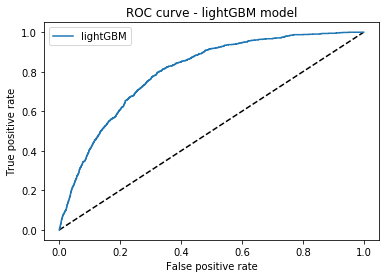

In [11]:
fpr_rf, tpr_rf, _ = roc_curve(test_set['target'].values, predict)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='lightGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - lightGBM model')
plt.legend(loc='best')
plt.show()

In [14]:
print('valid auc', roc_auc_score(test_set['target'].values, predictions_lgb))

valid auc 0.6631076641479327


<Figure size 432x288 with 0 Axes>

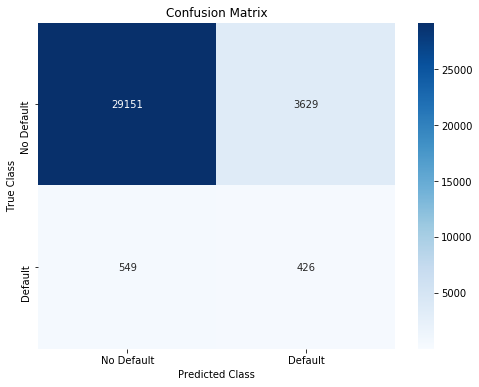

In [15]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_set['target'].values, predictions_lgb)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [16]:
#Print accuracy
acc_lgbm = accuracy_score(test_set['target'].values, predictions_lgb)
print('Overall accuracy of Light GBM model:', acc_lgbm)

Overall accuracy of Light GBM model: 0.8762257443341727


In [79]:
# Get the best paramter
parameters = {
     'reg_alpha': [0.1, 1, 10],
     'reg_lambda': [0.1, 1, 10],
     'feature_fraction': [0.5, 0.7, 0.9],
     'max_depth': [4, 6, 8],
     'num_leaves': [20, 30],
     'scale_pos_weight': [15, 25, 35],
     'num_iterations': [200, 2000],
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         metric = 'auc',
                         boosting_type= 'gbdt',
                         max_depth = 4,
                         num_leaves = 25,
                         learning_rate = 0.1,
                         feature_fraction = 0.7,
                         min_data_in_leaf = 5,
                         bagging_fraction = 0.7,
                         bagging_freq = 5,
                         reg_alpha = 10,
                         reg_lambda = 0.1,
                         num_iterations = 200,
                         scale_pos_weight = 10,
                         max_bin = 200,
                         verbose = 0,
                        )
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=3)
gsearch.fit(x_train, y_train)
print('The best parameter: {0}'.format(gsearch.best_params_))
print('best score of auc: {0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead

In [80]:
print('The best parameter: {0}'.format(gsearch.best_params_))
print('best score of auc: {0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

The best parameter: {'feature_fraction': 0.5, 'max_depth': 4, 'num_iterations': 200, 'num_leaves': 20, 'reg_alpha': 10, 'reg_lambda': 10, 'scale_pos_weight': 15}
best score of auc: 0.8378350870817405
[0.83179222 0.82868829 0.82635358 0.83084537 0.8302158  0.82523899
 0.83421928 0.83225158 0.83090899 0.83158146 0.82973967 0.82828316
 0.8307367  0.82951192 0.82548882 0.83498016 0.83256525 0.83206118
 0.83396266 0.8308539  0.82865077 0.83417165 0.83187375 0.83063818
 0.83783509 0.83566373 0.8321181  0.83179222 0.82868829 0.82635358
 0.83084537 0.8302158  0.82523899 0.83421928 0.83225158 0.83090899
 0.83158146 0.82973967 0.82828316 0.8307367  0.82951192 0.82548882
 0.83498016 0.83256525 0.83206118 0.83396266 0.8308539  0.82865077
 0.83417165 0.83187375 0.83063818 0.83783509 0.83566373 0.8321181
 0.7822887  0.78138257 0.77901244 0.78806235 0.78340496 0.78174892
 0.79801825 0.79552452 0.7956502  0.79099855 0.78704159 0.78424745
 0.78920506 0.78798425 0.78683622 0.79793726 0.79504756 0.796550

In [25]:
lgb_train = lgb.Dataset(x_train, y_train, 
                            categorical_feature ={'sex', 'merriage', 'income', 'qq_bound',
                                                  'degree', 'wechat_bound', 'account_grade'})
#lgb_test = lgb.Dataset(x_test, categorical_feature={'sex', 'merriage', 'income', 'qq_bound',
                                                  #'degree', 'wechat_bound', 'account_grade'})
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrix': 'auc',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'max_bin': 200,
    'verbose': 0,
    'scale_pos_weight':15,
    'reg_alpha':10,
    'reg_lambda':10,
    'max_depth':4,
}
gbm = lgb.train(params, lgb_train, num_boost_round=200)
predict = gbm.predict(x_test)
min_pred = min(predict)
max_pred = max(predict)
lgb_result = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))

D:\anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [26]:
result = lgb_result(predict)
predictions_lgb = np.where(result > 0.5, 1, 0)

In [27]:
print('valid auc', roc_auc_score(test_set['target'].values, predictions_lgb))

valid auc 0.6458311822405782


In [28]:
print('valid auc', roc_auc_score(test_set['target'].values, result))

valid auc 0.8119575413400917


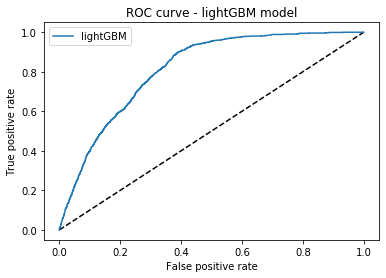

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(test_set['target'].values, predict)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='lightGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - lightGBM model')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

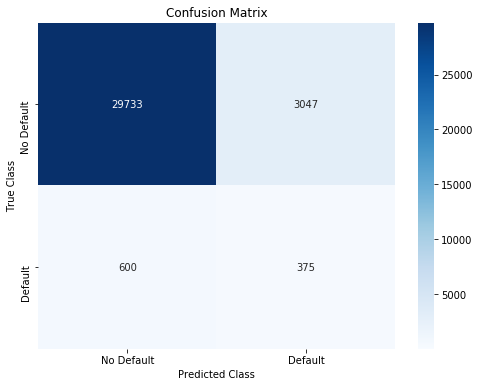

In [30]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_set['target'].values, predictions_lgb)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [31]:
#Print accuracy
acc_lgbm = accuracy_score(test_set['target'].values, predictions_lgb)
print('Overall accuracy of Light GBM model:', acc_lgbm)

Overall accuracy of Light GBM model: 0.8919567471485705


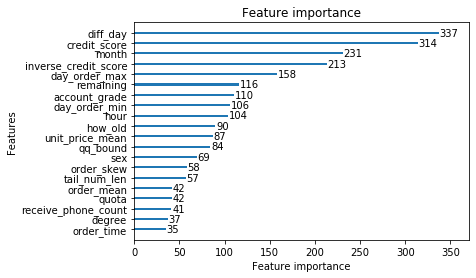

In [33]:
#Plot Variable Importances
lgb.plot_importance(gbm, max_num_features=20, importance_type='split', grid=False)

### select top 20 features to do prediciton again

In [40]:
# Create the pandas DataFrame 
lst = ['diff_day', 'credit_score', 'month', 'inverse_credit_score', 
       'day_order_max', 'remaining', 'account_grade', 'day_order_min', 
       'hour', 'how_old', 'unit_price_mean','qq_bound', 'sex', 'order_skew',
      'tail_num_len', 'order_mean', 'quota', 'receive_phone_count', 'degree', 'order_time', 'target', 'appl_sbm_tm']
sel_data = pd.DataFrame(data, columns = lst) 

In [41]:
sel_data.head()

,diff_day,credit_score,month,inverse_credit_score,day_order_max,remaining,account_grade,day_order_min,hour,how_old,...,sex,order_skew,tail_num_len,order_mean,quota,receive_phone_count,degree,order_time,target,appl_sbm_tm
0,34.0,394.0,4,211.0,439.0,0.00,5,445.0,19,24.830137,...,1,1.653270,2,95.750000,0.0,0,8,4.0,0,2017-04-08 19:10:13
1,129.0,578.0,6,27.0,14.0,1768.86,5,1329.0,15,NaN,...,2,1.719580,3,387.042308,4416.0,3,8,13.0,0,2016-06-08 15:20:21
2,-417.0,402.0,4,203.0,685.0,0.00,2,685.0,11,37.865753,...,1,NaN,3,1837.000000,0.0,1,8,2.0,0,2016-04-27 11:36:27
3,NaN,579.0,3,26.0,2.0,21.00,5,430.0,8,30.241096,...,2,1.580385,5,1125.125833,15146.0,1,8,60.0,0,2017-03-30 08:45:55
4,-380.0,390.0,11,215.0,NaN,0.00,5,NaN,11,31.000000,...,1,NaN,3,NaN,0.0,2,8,1.0,0,2016-11-30 11:40:38


In [42]:
# split the training set and the testing set
train_set = sel_data[sel_data['appl_sbm_tm'] < datetime.datetime(2017,3,30)]
test_set = sel_data[sel_data['appl_sbm_tm'] >= datetime.datetime(2017,3,30)]

test_set = test_set.drop(['appl_sbm_tm'], axis=1)
train_set = train_set.drop(['appl_sbm_tm'], axis=1)

x_test = test_set.drop(['target'], axis=1)
x_train = train_set.drop(['target'], axis=1)

y_train = train_set.iloc[:, 0]
y_test = test_set.iloc[:, 0]

In [44]:
lgb_train = lgb.Dataset(x_train, y_train, 
                            categorical_feature ={'sex', 'qq_bound',
                                                  'degree', 'account_grade'})

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrix': 'auc',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'max_bin': 200,
    'verbose': 0,
    'scale_pos_weight':15,
    'reg_alpha':10,
    'reg_lambda':10,
    'max_depth':4,
}
gbm = lgb.train(params, lgb_train, num_boost_round=200)
predict = gbm.predict(x_test)
min_pred = min(predict)
max_pred = max(predict)
lgb_result = np.vectorize(lambda x: (x-min_pred)/(max_pred-min_pred))

In [45]:
result = lgb_result(predict)
predictions_lgb = np.where(result > 0.5, 1, 0)
print('valid auc', roc_auc_score(test_set['target'].values, result))

valid auc 0.7303168911625287


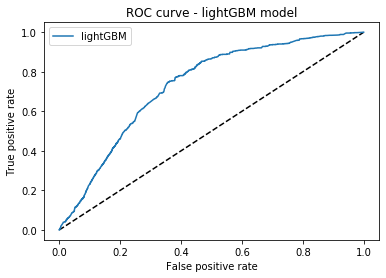

In [46]:
fpr_rf, tpr_rf, _ = roc_curve(test_set['target'].values, predict)
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='lightGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - lightGBM model')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

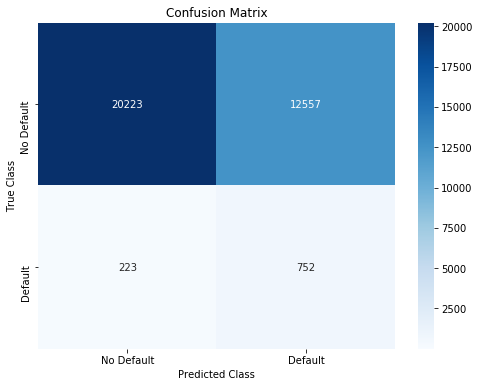

In [47]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_set['target'].values, predictions_lgb)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()